# 0. Import libraries

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# 1. Asses data

In [37]:
df = pd.read_excel('table.xlsx')

In [38]:
df.head()

,Unnamed: 0,position,article,paid per unit,amount,paid per position,reduced,original price per unit,original price per position,binding,quantity,unit,delivery_day,delivery_month,deliveryID,order-nr,add_day,add_month,pfand
0,0,1,Leimer Backerbsen,1.19,1,1.19,False,1.19,1.19,200g,200.0,g,16,9,1.pdf,806-062-0784,13,9,0.0
1,1,2,Radieschen,0.59,1,0.59,False,0.59,0.59,1 Bund,1.0,Bund,16,9,1.pdf,806-062-0784,13,9,0.0
2,2,3,Elinas Joghurt Honig Griechischer Art,1.89,1,1.89,False,1.89,1.89,4 x 150g,600.0,g,16,9,1.pdf,806-062-0784,13,9,0.0
3,3,4,Knorr Buchstaben Suppe,0.89,2,1.78,False,0.89,1.78,82g,82.0,g,16,9,1.pdf,806-062-0784,13,9,0.0
4,4,5,Knorr Hühnersuppe Nudeltopf Mix,0.89,2,1.78,False,0.89,1.78,69g,69.0,g,16,9,1.pdf,806-062-0784,13,9,0.0


# 2. Answering Questions

## 2.1 First Question: What are the 10 most common items we buy regularly?

### 2.1.1 Analyze <br>

Create a list of all unique entries of purchased items (`unique_article_list`) and calculate how often the item was purchased (`quantity_df`).

In [39]:
unique_article_list = pd.unique(df['article'])
quantity_df = pd.DataFrame([(list(df.groupby('article')['amount'])[i][0], sum(list(df.groupby('article')['amount'])[i][1])) for i in range(len(unique_article_list))], columns=['article','quantity'])

### 2.1.2 Visualize <br>

Create a bar chart with the ten most common items purchased in decreasing order.

<Axes: title={'center': 'the 10 most frequent ordered articles'}, xlabel='article'>

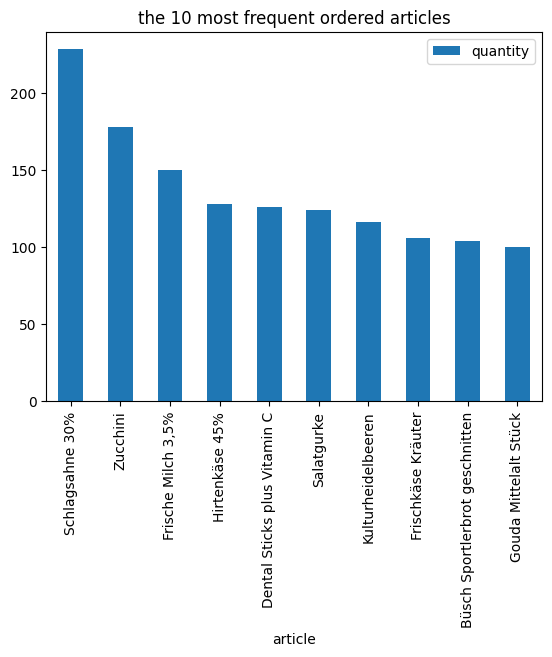

In [40]:
quantity_df.sort_values(by='quantity',ascending=False)[:10].plot(kind='bar', title='the 10 most frequent ordered articles', x='article')

## 2.2 Second Question: What items do we often buy together?

### 2.2.1 Analyze

Creates a new dataframe (`df_new`) with a column for each delivery ID and a row for each item. The table shows how many times an item was ordered in each delivery.

In [41]:
mat = np.array(pd.get_dummies(df['deliveryID']).replace({True: 1, False: 0}).transpose())
amount = np.array(df['amount'].transpose())
df_new = pd.DataFrame([amount * mat[line] for line in range(mat.shape[0])]).transpose()
df_new['article'] = df['article']
df_new = df_new.groupby('article').sum().reset_index()

Prepares a dataframe (`corr_df`) for the correlation analysis.

In [42]:
corr_df = df_new.drop('article',axis=1)
corr_df = corr_df.replace(0,np.nan)
corr_df = corr_df.transpose()

### 2.2.2 Model

Creates a corelation dataframe via the method `corr()`.

In [43]:
dfc = corr_df.corr(method='pearson',min_periods=14, numeric_only=True)

Removes the ones on the diagonal.

In [44]:
dfc = np.array(dfc)
for i in range(dfc.shape[0]):
    dfc[i][i] = np.nan

Converts the array to a dataframe and saves a copy in `dfc_abs` where the absolute values are saved.

In [45]:
dfc_abs = abs(pd.DataFrame(dfc))
dfc = pd.DataFrame(dfc)

Remove the ten most common items from the correlation dataframes.

In [48]:
dfc = dfc.drop(quantity_df.sort_values(by='quantity',ascending=False)[:10].index,axis=0)
dfc = dfc.drop(quantity_df.sort_values(by='quantity',ascending=False)[:10].index,axis=1)
dfc_abs = dfc_abs.drop(quantity_df.sort_values(by='quantity',ascending=False)[:10].index,axis=0)
dfc_abs = dfc_abs.drop(quantity_df.sort_values(by='quantity',ascending=False)[:10].index,axis=1)

### 2.2.3 Visualize

Just select the correlations above the threshold `thresh` for the visualization. Filter it in the `dfc_abs`.

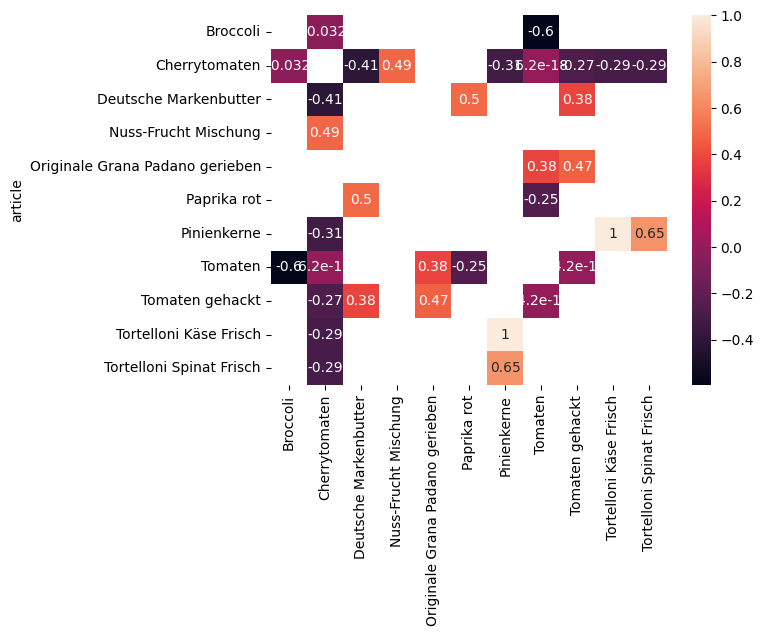

In [50]:
thresh = 0.45

ndf = pd.DataFrame(dfc.loc[dfc_abs.max(axis=1) > thresh, dfc_abs.max(axis=0) > thresh])
ndf['article'] = df_new['article'][quantity_df.sort_values(by='quantity',ascending=False)[10:].index].sort_index()
ndf = ndf.set_index('article')
ndf = ndf.rename(columns=df_new['article'][quantity_df.sort_values(by='quantity',ascending=False)[10:].index].sort_index())

sns.heatmap(ndf, annot=True)
plt.show()

## 2.3 Third Question: What influence does the price reduction and the season have on our shopping behavior?

**Dependent Variable:** 
+ amount per delivery 
<br>
<br>

**Independent Variable:** 
+ reduced
+ saving = paid per unit - original price per unit
+ seasonal influence

### 2.3.1 Analyze

Get the delivery number from the delivery ID

In [51]:
df['deliveryNo'] = [int(ID.split('.')[0]) for ID in df['deliveryID']]

Create y for the 100 most frequent purchased items (`y_all`). `y_all` is a dataframe with one row for every item and one column for every delivery with the purchased amount of the item.

In [52]:
mat = np.array(pd.get_dummies(df['deliveryNo']).replace({True: 1, False: 0}).transpose())
amount = np.array(df['amount'].transpose())
df_new = pd.DataFrame([amount * mat[line] for line in range(mat.shape[0])]).transpose()
df_new['delivery'] = df['article']
df_new = df_new.groupby('delivery').sum().reset_index()
y_all = df_new.transpose()
y_all = y_all[quantity_df.sort_values(by='quantity',ascending=False)[:100].index]
y_all.columns = y_all.iloc[0]
y_all = y_all.drop('delivery', axis=0)

Creates a dataframe (`X_reduced`) with binary values. The dataframe has one row for every item and one column for every delivery with a 1, if the item was reduced in this delivery and a 0 if not.

In [53]:
mat = np.array(pd.get_dummies(df['deliveryNo']).replace({True: 1, False: 0}).transpose())
reduced = np.array(df['reduced'].replace({True: 1, False: 0}).transpose())
df_new = pd.DataFrame([reduced * mat[line] for line in range(mat.shape[0])]).transpose()
df_new['delivery'] = df['article']
X_reduced = df_new.groupby('delivery').max().reset_index().transpose()
X_reduced = X_reduced[quantity_df.sort_values(by='quantity',ascending=False)[:100].index]
X_reduced.columns = X_reduced.iloc[0]
X_reduced = X_reduced.drop('delivery', axis=0)

Creates a dataframe (`X_month`) with the month of every delivery and transforms the month to the season.

In [54]:
X_month = df.groupby('deliveryNo')['delivery_month'].max()
X_month = X_month.replace({1: 'winter',
                2: 'winter',
                3: 'winter',
                4: 'spring',
                5: 'spring',
                6: 'spring',
                7: 'summer',
                8: 'summer',
                9: 'summer',
                10: 'fall',
                11: 'fall',
                12: 'fall'})
X_month = pd.get_dummies(X_month).replace({True: 1, False: 0})

Creates a dataframe (`X_saving`) with one row for every item and one column fpr every delivery. The dataframe shows the difference between the paid price and the original price for an item in every delivery.

In [55]:
mat = np.array(pd.get_dummies(df['deliveryNo']).replace({True: 1, False: 0}).transpose())
saving = df['original price per unit'] - df['paid per unit']
df_new = pd.DataFrame([saving * mat[line] for line in range(mat.shape[0])]).transpose()
df_new['delivery'] = df['article']
X_saving = df_new.groupby('delivery').max().reset_index().transpose()
X_saving = X_saving[quantity_df.sort_values(by='quantity',ascending=False)[:100].index]
X_saving.columns = X_saving.iloc[0]
X_saving = X_saving.drop('delivery', axis=0)

### 2.3.2 Model

Create one linear regression model for every item. Split the dataq into train and test and fit the model with the train data. Calcualte the R2 Score with the test data and save the intercept, coefficients and r2 in dataframes (`intercept`, `coef_df` and `r2_df`).

In [56]:
items = X_reduced.columns
coef_array = []
r2score_array = []
intercept_array = []

for item in items:

    lm_model = LinearRegression()

    all_data = pd.DataFrame(X_month.reset_index().drop('deliveryNo',axis=1))
    all_data['saving'] = X_saving[item]
    all_data['reduced'] = X_reduced[item]
    all_data['amount'] = y_all[item]
    all_data.columns = all_data.columns.astype(str)

    y = all_data[all_data['amount']>0]['amount']

    X = all_data[all_data['amount']>0]
    X = X.drop('amount', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

    lm_model.fit(X_train, y_train)

    y_pred = lm_model.predict(X_test)

    r2score_array.append(r2_score(y_test, y_pred))
    coef_array.append(lm_model.coef_)
    intercept_array.append(lm_model.intercept_)

coef_df = pd.DataFrame(coef_array)
r2_df = pd.DataFrame(r2score_array)
intercept = pd.DataFrame(intercept_array)

### 2.3.3 Visualize

Create a dataframe (`fita`) with the coefficients, r2 scores, intercepts and item names.

In [57]:
column_names = ['winter', 'spring', 'summer', 'fall', 'saving', 'reduced', 'R2', 'intercept', 'article']
fita = pd.concat([coef_df, r2_df, intercept, pd.DataFrame(items.values)],axis=1)
fita.columns = column_names

Save all items where no influence was measured in `no_infl`.

In [58]:
no_infl = fita[(fita[['winter', 'spring', 'summer', 'fall', 'saving', 'reduced']]==0).all(axis=1)]

Save all Items with r2 score <= 0 in `no_expl`.

In [59]:
not_null = fita[(fita[['winter', 'spring', 'summer', 'fall', 'saving', 'reduced']]>0).any(axis=1)]
no_expl = not_null[not_null['R2']<=0].sort_values(by='R2',ascending=False)

Save all items where influence might be existend in `expl`.

In [60]:
expl = not_null[not_null['R2']>0].sort_values(by='R2',ascending=False)

Visualize the item with the highest r2 score an influence.

<Axes: title={'center': 'Influence on amount purchased'}, xlabel='Intrigo Intrigo Negroamaro'>

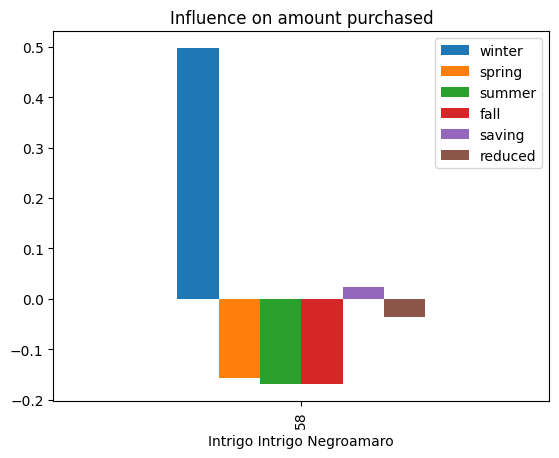

In [61]:
expl[['winter', 'spring', 'summer', 'fall', 'saving', 'reduced']][:1].plot(kind='bar',xlabel=items[expl[['winter', 'spring', 'summer', 'fall', 'saving', 'reduced']][:1].index][0],title='Influence on amount purchased',)